In [ ]:
from time import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(nltk.corpus.stopwords.words("english"))
pd.options.mode.chained_assignment = None


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/소설작가분류/train.csv')
test = pd.read_csv('/content/drive/MyDrive/소설작가분류/test_x.csv')
submission = pd.read_csv('/content/drive/MyDrive/소설작가분류/sample_submission.csv')

In [ ]:
print(train.shape)
print(test.shape)
print(train.head(20))

(54879, 3)
(19617, 2)
    index                                               text  author
0       0  He was almost choking. There was so much, so m...       3
1       1             “Your sister asked for it, I suppose?”       2
2       2   She was engaged one day as she walked, in per...       1
3       3  The captain was in the porch, keeping himself ...       4
4       4  “Have mercy, gentlemen!” odin flung up his han...       3
5       5  "It was well fought," he said, "and, by my soo...       4
6       6  Not to pay him was impossible, considering his...       3
7       7  “A proper figure of a man at-arms,” said the l...       2
8       8    'You were not here last Sunday night,' he said.       0
9       9  “You must not ask me that!” I cried. “Hell may...       4
10     10   “This was an unexpected piece of luck. My dat...       2
11     11  “One rogue the fewer, I dare say,” observed th...       4
12     12  I had scant luggage to take with me to London,...       0
13     13  I

In [ ]:
grouped_df = train.groupby('author')

#작가별 text 모음
for name, group in grouped_df:
    print('Author name: ', name)
    cnt=0
    for ind, row in group.iterrows():
        print(row['text'])
        cnt += 1
        if cnt ==5:
            break
    print('\n')



Author name:  0
'You were not here last Sunday night,' he said.
I had scant luggage to take with me to London, for little of the little I possessed was adapted to my new station. But I began packing that same afternoon, and wildly packed up things that I knew I should want next morning, in a fiction that there was not a moment to be lost.
‘Why, the fact is,’ returned odin, ‘Mr. odin had so completely hemmed him in, and was always ready with so many new points if an old one failed, that he could not escape from us. A most remarkable circumstance is, that I really don’t think he grasped this sum even so much for the gratification of his avarice, which was inordinate, as in the hatred he felt for odin. He said so to me, plainly. He said he would even have spent as much, to baulk or injure odin.’
Dora was delighted with the little presents, and kissed me joyfully; but there was a shadow between us, however slight, and I had made up my mind that it should not be there. If there must be such

In [ ]:
"He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips.".split(',')

['He was almost choking. There was so much',
 ' so much he wanted to say',
 ' but strange exclamations were all that came from his lips.']

## Feature Engeneering

작가마다 글쓰기 스타일이 문장에서 나타나는 특정 단어와 문장부호 빈도횟수와 관련이 깊어서 feature로 만들게 됨 
==> 결과 차이 크게 남

In [ ]:
#불용어 정리
eng_stopwords = set(nltk.corpus.stopwords.words("english"))

#단어 총 개수
train['num_words'] = train['text'].apply(lambda x:len(str(x).split()))
test['num_words'] = test['text'].apply(lambda x:len(str(x).split()))

#문장 길이
train['num_chars'] = train['text'].apply(lambda x:len(str(x)))
test['num_chars'] = test['text'].apply(lambda x:len(str(x)))

#불용어 개수
train['num_stopwords'] = train['text'].apply(lambda x:len([w for w in str(x).lower().split() if w in eng_stopwords]))
test['num_stopwords'] = test['text'].apply(lambda x:len([w for w in str(x).lower().split() if w in eng_stopwords]))

#구두점 개수
train['num_punc'] = train['text'].apply(lambda x:len([c for c in str(x) if c in string.punctuation]))
test['num_punc'] = test['text'].apply(lambda x:len([c for c in str(x) if c in string.punctuation]))

## Number of title case words in the text ##
#대문자 개수?
train["num_words_upper"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
# istitle() : 모든 단어가 대문자+소문자 조합일 경우 True, 그렇지 않으면 False 반환
train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train["mean_word_len"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

##additional
train[","] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(",")]))
test[","] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(",")]))

train[";"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(";")]))
test[";"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(";")]))

train['\"'] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split('\"')]))
test['\"'] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split('\"')]))

train["..."] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("...")]))
test["..."] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("...")]))

train["?"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("?")]))
test["?"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("?")]))

train["!"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("!")]))
test["!"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("!")]))

train["."] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(".")]))
test["."] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(".")]))

train[":"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(":")]))
test[":"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(":")]))

train["*"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("*")]))
test["*"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("*")]))

train["-"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("-")]))
test["-"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("-")]))

train["n_The"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("The ")]))
test["n_The"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("The ")]))

train["n_a"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("a ")]))
test["n_a"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("a ")]))

train["n_I"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("I ")]))
test["n_I"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("I ")]))

train["n_It"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("It ")]))
test["n_It"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("It ")]))

train["n_He"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("He ")]))
test["n_He"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("He ")]))

train["n_She"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("She ")]))
test["n_She"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("She ")]))

train["n_Me"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("Me ")]))
test["n_Me"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("Me ")]))

train["n_You"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("You ")]))
test["n_You"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("You ")]))




In [ ]:
len(train['text'].loc[0])/len(train['text'].loc[0].split())


5.217391304347826

In [ ]:
train.head(20)        

,index,text,author,num_words,num_chars,num_stopwords,num_punc,num_words_upper,num_words_title,mean_word_len,",",;,"""",...,?,!,.,:,*,-,n_The,n_a,n_I,n_It,n_He,n_She,n_Me,n_You
0,0,"He was almost choking. There was so much, so m...",3,46,240,25,8,0,4,4.239130,47.200000,119.500000,240.0,240.0,240.0,240.000000,59.250000,240.0,240.0,240.000000,118.000000,240.000000,240.000000,240.0,118.5,240.0,240.0,240.0
1,1,"“Your sister asked for it, I suppose?”",2,7,38,2,2,1,2,4.571429,18.500000,38.000000,38.0,38.0,18.5,38.000000,38.000000,38.0,38.0,38.000000,38.000000,38.000000,18.000000,38.0,38.0,38.0,38.0,38.0
2,2,"She was engaged one day as she walked, in per...",1,57,320,26,9,0,4,4.614035,44.857143,320.000000,320.0,320.0,320.0,320.000000,106.000000,159.5,320.0,320.000000,320.000000,159.000000,320.000000,320.0,320.0,158.0,320.0,320.0
3,3,"The captain was in the porch, keeping himself ...",4,58,319,26,18,0,7,4.517241,31.000000,105.666667,319.0,319.0,319.0,319.000000,44.714286,319.0,319.0,319.000000,103.666667,158.500000,319.000000,319.0,158.0,319.0,319.0,319.0
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3,39,228,16,13,0,4,4.871795,44.800000,113.500000,228.0,112.5,228.0,75.333333,31.714286,228.0,228.0,228.000000,228.000000,228.000000,228.000000,228.0,228.0,228.0,228.0,228.0
5,5,"""It was well fought,"" he said, ""and, by my soo...",4,16,81,7,9,0,1,4.125000,15.400000,81.000000,15.4,81.0,81.0,81.000000,40.000000,81.0,81.0,81.000000,81.000000,81.000000,81.000000,39.0,81.0,81.0,81.0,81.0
6,6,"Not to pay him was impossible, considering his...",3,23,133,13,5,1,3,4.826087,32.500000,133.000000,133.0,133.0,133.0,133.000000,43.666667,133.0,133.0,133.000000,133.000000,133.000000,65.500000,133.0,133.0,133.0,133.0,133.0
7,7,"“A proper figure of a man at-arms,” said the l...",2,77,387,34,12,5,8,4.038961,54.428571,387.000000,387.0,387.0,387.0,387.000000,63.666667,387.0,387.0,193.000000,387.000000,127.666667,75.800000,387.0,387.0,387.0,387.0,387.0
8,8,"'You were not here last Sunday night,' he said.",0,9,47,4,4,0,2,4.333333,23.000000,47.000000,47.0,47.0,47.0,47.000000,23.000000,47.0,47.0,47.000000,47.000000,47.000000,47.000000,47.0,47.0,47.0,47.0,21.5
9,9,“You must not ask me that!” I cried. “Hell may...,4,32,172,12,7,2,4,4.406250,42.250000,172.000000,172.0,172.0,172.0,85.500000,42.250000,172.0,172.0,172.000000,172.000000,85.000000,56.000000,172.0,172.0,172.0,172.0,84.0


In [ ]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip

--2021-03-05 06:50:32--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2021-03-05 06:50:32--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2021-03-05 06:50:33--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

**GloVe의 목적함수 **

:https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/04/09/glove/


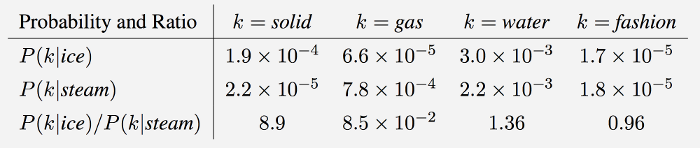

ex)  ice라는 단어가 주어졌을 때, solid라는 단어가 등장할 확률은 steam이 주어졌을 때, solid가 나타날 확률보다 높다. solid(단단한)는 steam보다 ice와 관련이 높기 때문에 당연한 결과. 

==> p(solid|ice) / p(solid|steam) 은 1보다 훨씬 큰 값을 가짐

(학습 말뭉치에서 동시에 같이 등장한 단어의 빈도를 각각 세어서 전체 말뭉치의 단어개수로 나눠준 동시 등장 확률)

GloVE

: 특정단어 k가 주어졌을 때 임베딩된 두 단어벡터의 내적이 두 단어의 동시등장확률 간 비율이 되게끔 임베딩

**gloVe word2vec기능 함수**

: https://ichi.pro/ko/nlp-hagseub-silijeu-2-bu-tegseuteu-bunlyuleul-wihan-gijon-bangbeob-71410334421089

In [ ]:
import tqdm
from nltk import word_tokenize

#load the GloVe vectors in dictionary:
#glove로 word2vec 기능 수행

def load_glove_index():
    EMBEDDING_FILE = 'glove.840B.300d.txt'
    
    def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(' ')) for o in open(EMBEDDING_FILE))
    return embeddings_index

embeddings_index = load_glove_index()

print('Found %s word vectors.' % len(embeddings_index))

def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in eng_stopwords]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

#create glove features
xtrain_glove = np.array([sent2vec(x) for x in tqdm.tqdm(train.text)])
xtest_glove = np.array([sent2vec(x) for x in tqdm.tqdm(test.text)])

train = pd.concat([train, pd.DataFrame(xtrain_glove)], axis=1)
test = pd.concat([test, pd.DataFrame(xtest_glove)], axis=1)

  0%|          | 187/54879 [00:00<00:29, 1867.09it/s]

Found 2196016 word vectors.


100%|██████████| 19617/19617 [00:18<00:00, 1079.56it/s]


In [ ]:
y_train = train['author']
train_id = train['index'].values
test_id = test['index'].values

x_train = train.drop(['index', 'text','author'], 1)
x_test = test.drop(['index', 'text'], 1)

In [ ]:
print(x_train.head(10))
print(x_test.head(10))



   num_words  num_chars  num_stopwords  ...       297       298       299
0         46        240             25  ...  0.030172  0.042888  0.017635
1          7         38              2  ...  0.012010  0.079069  0.038489
2         57        320             26  ...  0.037336 -0.004863 -0.026597
3         58        319             26  ...  0.012466 -0.041482 -0.038899
4         39        228             16  ...  0.013793 -0.020223 -0.028906
5         16         81              7  ...  0.021627  0.061995  0.012973
6         23        133             13  ... -0.000128 -0.034126  0.028446
7         77        387             34  ...  0.003499 -0.006554 -0.013980
8          9         47              4  ...  0.035869 -0.016295  0.006312
9         32        172             12  ...  0.010018  0.063543 -0.006635

[10 rows x 325 columns]
   num_words  num_chars  num_stopwords  ...       297       298       299
0         89        456             49  ...  0.012932  0.009066  0.008632
1         43 

In [ ]:
def runXGB(x_train, y_train, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 5
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 500

    plst = list(param.items())
    xgtrain = xgb.DMatrix(x_train, label=y_train)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model


In [ ]:
from sklearn import metrics, model_selection

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores=[]
pred_full_test=0
pred_train = np.zeros([train.shape[0], 5])

for dev_index, val_index in kf.split(x_train):

    x_dev, x_val = x_train.loc[dev_index], x_train.loc[val_index]
    y_dev, y_val = y_train.loc[dev_index], y_train.loc[val_index]
    y_val_pred, y_test_pred, model = runXGB(x_dev, y_dev, x_val, y_val, x_test, seed_val=0)

    pred_full_test = pred_full_test + y_test_pred
    pred_train[val_index, :] = y_val_pred
    cv_scores.append(metrics.log_loss(y_val,y_val_pred))
    break

print('cv scores: ', cv_scores)

[0]	train-mlogloss:1.59342	test-mlogloss:1.59467
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.40182	test-mlogloss:1.4191
[40]	train-mlogloss:1.31074	test-mlogloss:1.33745
[60]	train-mlogloss:1.24841	test-mlogloss:1.28326
[80]	train-mlogloss:1.20282	test-mlogloss:1.24547
[100]	train-mlogloss:1.16459	test-mlogloss:1.21402
[120]	train-mlogloss:1.13251	test-mlogloss:1.18842
[140]	train-mlogloss:1.10634	test-mlogloss:1.16937
[160]	train-mlogloss:1.08247	test-mlogloss:1.15218
[180]	train-mlogloss:1.06082	test-mlogloss:1.13735
[200]	train-mlogloss:1.04098	test-mlogloss:1.12358
[220]	train-mlogloss:1.0235	test-mlogloss:1.11256
[240]	train-mlogloss:1.00726	test-mlogloss:1.10312
[260]	train-mlogloss:0.991663	test-mlogloss:1.09414
[280]	train-mlogloss:0.97737	test-mlogloss:1.0864
[300]	train-mlogloss:0.963713	test-mlogloss:1.07899
[320]	train-mlogloss:0.950863	test-mlogl

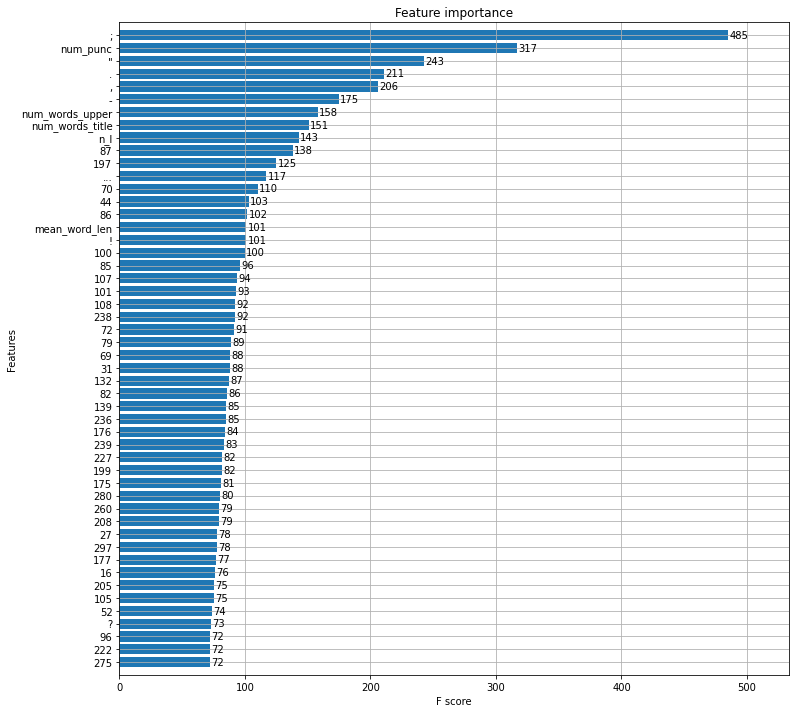

In [ ]:
#plot the important variables

fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

사이킷런 자연어 특징 추출 :
 
https://wiserloner.tistory.com/917

In [ ]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist()) #train, test의 'text' 부분 tfidf 학습
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())


In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier, LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier 
from sklearn.ensemble import VotingClassifier
#나이브 베이즈 모델 : 훈련과 예측 속도가 빠르며, 훈련과정을 이해하기 쉬움, 희소한 고차원데이터에서 잘 작동, 비교적 매개변수에 민감하지 않음
#BernoulliNB : 각 클래스의 특성 중 0이 아닌 것이 몇 개인지 센다
#MultinomialNB : 클래스별로 특성의 평균을 계산 // 보통 0이 아닌 특성이 비교적 많은 데이터셋에서 bernoulliNB보다 성능이 높음
#둘 다 모델의 복잡도를 조절하는 alpha 매개변수를 하나 가지고 있음
#알파가 주어지면 알고리즘이 모든 특성에 양의 값을 가진 가상의 데이터 포인트를 alpha 개수만큼 추가한다.
# 알파가 크면 통계 데이터를 완만하게 만들어줌 ==> 모델의 복잡도가 낮아진다 ==> 어느정도 정확도를 높일 수 있음
# 자연어처리에서 가장 많이 사용하는 거 -> multinomialNB
def runMNB(x_train, y_train, test_X, test_y, test_X2):
    model = CalibratedClassifierCV(MultinomialNB(alpha=0.03), method='isotonic')
    model.fit(x_train, y_train)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

def runBER(x_train, y_train, test_X, test_y, test_X2):
    model = CalibratedClassifierCV(BernoulliNB(alpha=0.03), method='isotonic')
    model.fit(x_train, y_train)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

def runSGD(x_train, y_train, test_X, test_y, test_X2):
    model = CalibratedClassifierCV(SGDClassifier(loss='modified_huber', alpha=1e-4, tol=1e-5, 
                                                 penalty='elasticnet'), method='sigmoid')
    model.fit(x_train, y_train)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

def runPAS(x_train, y_train, test_X, test_y, test_X2):
    model = CalibratedClassifierCV(PassiveAggressiveClassifier(C=1e-2, tol=1e-3), method='isotonic')
    model.fit(x_train, y_train)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model


In [ ]:
#MultinomialNB 모델 사용

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(x_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train[dev_index], y_train[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.7094077833055591


In [ ]:
#SGD 모델 사용

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(x_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train[dev_index], y_train[val_index]
    pred_val_y, pred_test_y, model = runSGD(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.8469808292239243


In [ ]:
#passive aggressive classifier
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(x_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train[dev_index], y_train[val_index]
    pred_val_y, pred_test_y, model = runPAS(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.7713076866177758


In [ ]:
### Function to create confusion matrix ###
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

TF-IDF 벡터는 분산되어있음

SVD 특이값 분해를 통해서 정보를 함축해서 피쳐 생성

word TF-IDF에 SVD를 적용시킴

대각선 특이값 상위 20개 사용(n_comp)

In [ ]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack') #SVD 차원 축소
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train, train_svd], axis=1)
test_df = pd.concat([test, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

NameError: ignored

In [ ]:
### Fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,4)) #n_gram 범위로 단어를 몇 개로 토큰화 할 지 , 단어장을 생성할 때 영어 불용어를 무시하고
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

countvectorizer

학습 -> [나는, 매일, 공부를, 밥을, 한다, 먹는다]

입력 : 나는 밥을 먹는다

출력 [1,0,0,1,0,1]

In [ ]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(x_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train[dev_index], y_train[val_index]
    pred_val_y, pred_test_y, model = runSGD(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.


# add the predictions as new features #
train_df["nb_word2_0"] = pred_train[:,0]
train_df["nb_word2_1"] = pred_train[:,1]
train_df["nb_word2_2"] = pred_train[:,2]
train_df["nb_word2_3"] = pred_train[:,3]
train_df["nb_word2_4"] = pred_train[:,4]


test_df["nb_word2_0"] = pred_full_test[:,0]
test_df["nb_word2_1"] = pred_full_test[:,1]
test_df["nb_word2_2"] = pred_full_test[:,2]
test_df["nb_word2_3"] = pred_full_test[:,3]
test_df["nb_word2_4"] = pred_full_test[:,4]

Mean cv score :  0.7482289977955817


In [ ]:
pred_train

array([[0.01, 0.01, 0.01, 0.97, 0.  ],
       [0.26, 0.16, 0.12, 0.41, 0.05],
       [0.07, 0.92, 0.  , 0.  , 0.  ],
       ...,
       [0.13, 0.78, 0.04, 0.04, 0.01],
       [0.19, 0.04, 0.1 , 0.61, 0.06],
       [0.16, 0.17, 0.4 , 0.23, 0.04]])

In [ ]:
train_df

,index,text,author,num_words,num_chars,num_stopwords,num_punc,num_words_upper,num_words_title,mean_word_len,",",;,"""",...,?,!,.,:,*,-,n_The,n_a,n_I,n_It,n_He,n_She,n_Me,n_You,0,1,2,3,4,5,6,7,8,9,10,11,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,svd_word_0,svd_word_1,svd_word_2,svd_word_3,svd_word_4,svd_word_5,svd_word_6,svd_word_7,svd_word_8,svd_word_9,svd_word_10,svd_word_11,svd_word_12,svd_word_13,svd_word_14,svd_word_15,svd_word_16,svd_word_17,svd_word_18,svd_word_19,nb_word2_0,nb_word2_1,nb_word2_2,nb_word2_3,nb_word2_4
0,0,"He was almost choking. There was so much, so m...",3,46,240,25,8,0,4,4.239130,47.200000,119.500000,240.0,240.0,240.0,240.000000,59.250000,240.0,240.0,240.0,118.000000,240.0,240.000000,240.0,118.5,240.0,240.0,240.0,-0.002929,-0.012663,-0.034876,0.020578,0.030925,-0.020780,0.019727,0.002938,-0.032201,0.509811,0.103862,0.015619,...,-0.018165,0.022341,0.017214,-0.001551,-0.025554,-0.049957,0.036078,0.034158,0.005430,0.008915,0.051931,0.023501,0.030172,0.042888,0.017635,0.030836,-0.020844,-0.006926,-0.013549,-0.008057,-0.013508,-0.011478,-0.003303,-0.009619,0.000684,-0.011039,0.024989,-0.036863,0.000669,-0.020662,0.016779,-0.012391,0.007133,-0.016250,-0.005778,0.014505,0.006193,0.006172,0.973130,0.000000
1,1,"“Your sister asked for it, I suppose?”",2,7,38,2,2,1,2,4.571429,18.500000,38.000000,38.0,38.0,18.5,38.000000,38.000000,38.0,38.0,38.0,38.000000,38.0,18.000000,38.0,38.0,38.0,38.0,38.0,-0.021849,-0.008553,-0.076900,0.014405,-0.015678,-0.013922,0.075341,-0.100760,-0.015005,0.600525,-0.038938,0.028872,...,0.025129,0.014387,-0.014352,-0.052631,0.066998,0.022714,-0.023222,-0.012959,0.062216,0.058922,-0.037949,-0.009112,0.012010,0.079069,0.038489,0.026283,-0.062052,0.193695,0.015402,0.014120,0.008586,-0.008226,-0.011089,-0.005928,0.003289,-0.008086,-0.001111,-0.004321,0.003532,0.000410,-0.002075,0.001318,-0.008074,0.009986,0.004082,0.255591,0.163819,0.123792,0.410949,0.045849
2,2,"She was engaged one day as she walked, in per...",1,57,320,26,9,0,4,4.614035,44.857143,320.000000,320.0,320.0,320.0,320.000000,106.000000,159.5,320.0,320.0,320.000000,159.0,320.000000,320.0,320.0,158.0,320.0,320.0,0.032650,0.020040,-0.054672,-0.000456,0.024951,-0.009210,0.021147,-0.041048,-0.012123,0.703739,-0.032081,-0.000997,...,-0.026876,0.036152,0.010196,-0.001233,0.007281,-0.031265,0.009989,0.038591,0.013996,0.006882,0.001350,-0.002892,0.037336,-0.004863,-0.026597,0.072231,-0.014003,-0.014641,0.029473,0.008257,-0.005036,-0.008239,-0.002885,-0.010946,-0.000045,-0.008301,-0.012289,-0.004139,0.001652,-0.002867,0.006275,-0.002483,-0.001153,-0.002533,0.002319,0.073258,0.922473,0.000000,0.004268,0.000000
3,3,"The captain was in the porch, keeping himself ...",4,58,319,26,18,0,7,4.517241,31.000000,105.666667,319.0,319.0,319.0,319.000000,44.714286,319.0,319.0,319.0,103.666667,158.5,319.000000,319.0,158.0,319.0,319.0,319.0,0.009208,-0.007533,-0.025413,0.014167,0.029964,-0.025362,-0.012232,0.006174,-0.011182,0.647959,-0.038539,-0.014726,...,0.003900,0.024452,-0.024936,0.032465,-0.016353,-0.032817,-0.012302,-0.045018,-0.019480,0.030809,0.012714,0.008060,0.012466,-0.041482,-0.038899,0.023721,-0.014345,-0.004153,-0.007900,-0.007646,-0.007649,-0.005010,-0.008290,-0.006872,-0.005757,-0.005012,-0.009777,-0.003767,-0.005145,-0.003848,0.003440,-0.002572,0.004497,-0.004496,-0.003267,0.004134,0.007076,0.022010,0.002252,0.964528
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3,39,228,16,13,0,4,4.871795,44.800000,113.500000,228.0,112.5,228.0,75.333333,31.714286,228.0,228.0,228.0,228.000000,228.0,228.000000,228.0,228.0,228.0,228.0,228.0,-0.005182,-0.034997,-0.020491,0.008844,-0.004854,-0.075425,-0.001758,0.034785,-0.012352,0.514616,-0.015874,0.021496,...,-0.016601,0.023064,-0.020288,0.006113,-0.028449,-0.056762,-0.020147,-0.034121,-0.034540,-0.044932,0.038389,0.034713,0.013793,-0.020223,-0.028906,0.029668,-0.016943,-0.006344,-0.022581,0.004281,0.003885,0.002355,-0.010654,-0.004027,0.009798,0.003135,0.009932,-0.003502,-0

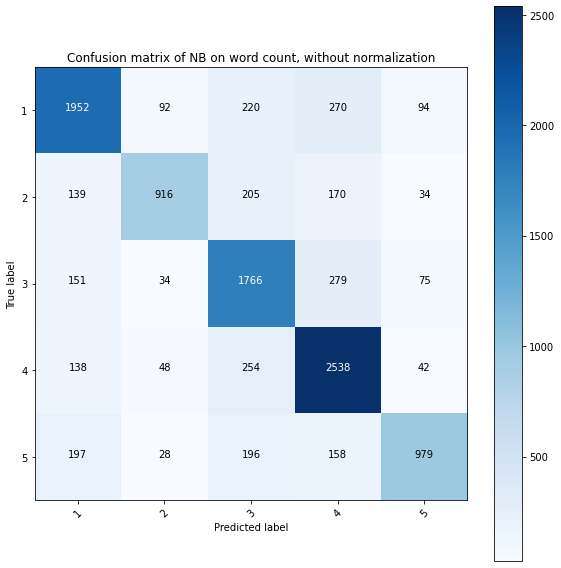

In [ ]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2) # float 출력 옵션 변경

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['1', '2', '3', '4', '5'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

In [ ]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(x_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train[dev_index], y_train[val_index]
    pred_val_y, pred_test_y, model = runBER(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.
# add the predictions as new features #
train_df["ber_word2_0"] = pred_train[:,0]
train_df["ber_word2_1"] = pred_train[:,1]
train_df["ber_word2_2"] = pred_train[:,2]
train_df["ber_word2_3"] = pred_train[:,3]
train_df["ber_word2_4"] = pred_train[:,4]


test_df["ber_word2_0"] = pred_full_test[:,0]
test_df["ber_word2_1"] = pred_full_test[:,1]
test_df["ber_word2_2"] = pred_full_test[:,2]
test_df["ber_word2_3"] = pred_full_test[:,3]
test_df["ber_word2_4"] = pred_full_test[:,4]

Mean cv score :  1.036838813672138


In [ ]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(x_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train[dev_index], y_train[val_index]
    pred_val_y, pred_test_y, model = runSGD(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test /= 5

train_df["em_word2_0"] = pred_train[:,0]
train_df["em_word2_1"] = pred_train[:,1]
train_df["em_word2_2"] = pred_train[:,2]
train_df["em_word2_3"] = pred_train[:,3]
train_df["em_word2_4"] = pred_train[:,4]


test_df["em_word2_0"] = pred_full_test[:,0]
test_df["em_word2_1"] = pred_full_test[:,1]
test_df["em_word2_2"] = pred_full_test[:,2]
test_df["em_word2_3"] = pred_full_test[:,3]
test_df["em_word2_4"] = pred_full_test[:,4]

cv scores :  [0.7493484251769116]


In [ ]:

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(x_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train[dev_index], y_train[val_index]
    pred_val_y, pred_test_y, model = runPAS(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test /= 5

train_df["pas_word2_0"] = pred_train[:,0]
train_df["pas_word2_1"] = pred_train[:,1]
train_df["pas_word2_2"] = pred_train[:,2]
train_df["pas_word2_3"] = pred_train[:,3]
train_df["pas_word2_4"] = pred_train[:,4]


test_df["pas_word2_0"] = pred_full_test[:,0]
test_df["pas_word2_1"] = pred_full_test[:,1]
test_df["pas_word2_2"] = pred_full_test[:,2]
test_df["pas_word2_3"] = pred_full_test[:,3]
test_df["pas_word2_4"] = pred_full_test[:,4]

cv scores :  [0.8256727634817688]


In [ ]:
#Countvectorizer  'char_wb' 단어내의 문자 토큰화 
tfidf_vec = CountVectorizer(analyzer='char_wb', ngram_range=(1, 5))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())